In [2]:
import numpy as np
import pandas as pd
from datetime import date, time, datetime
import re
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from statistics import mode
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict

import warnings
warnings.filterwarnings('ignore')

In [3]:
def read_txt_temp_min(data,year_i,year_f):
    datos = []
    with open(data, encoding='iso-8859-1') as fname:
	    lineas = fname.readlines()
	    for linea in lineas:
		    datos.append(linea.strip('\n'))
    years = range(year_i,year_f,1) 
    
    fechas = []
    temps_min = []

    #Barremos los anios
    for y in years :
    
        indice = datos.index(f'Año {y} Temperatura Mínima (°C)')
        indice_sig = datos.index(f'Año {y+1} Temperatura Mínima (°C)')
    
    #Barremos los dias
        for d in range(indice+4,indice_sig-2,1):
            d2 = datos[d]
            d2= re.sub(r" ", "",d2).split(";")
            
            dia = int(d2[0])
    # Barremos los meses    
            for m in range(len(d2)-2):               

                try:
                    fecha = date(day=dia, month=m+1, year=y)
                    fechas.append(fecha)                    
                    temp_min = d2[m+1]
                    if (d2[m+1] == 's/d'):
                        #print('no existe')
                        temp_min = float('nan')
                    else:
                        temp_min = float(d2[m+1].replace(',','.'))
                    temps_min.append(temp_min) 
                except ValueError as error_in_date:
                    pass
                

    df = pd.DataFrame()
    df['Fecha']= fechas
    df['temp_min']=temps_min
    df = df.sort_values(by='Fecha')
    df = df.set_index('Fecha')
    return df

In [4]:
def read_txt_temp_max(data,year_i,year_f):
    datos = []
    with open(data, encoding='iso-8859-1') as fname:
	    lineas = fname.readlines()
	    for linea in lineas:
		    datos.append(linea.strip('\n'))
    years = range(year_i,year_f,1) 
    
    fechas = []
    temps_min = []

    #Barremos los anios
    for y in years :
    
        indice = datos.index(f'Año {y} Temperatura Máxima (°C)')
        indice_sig = datos.index(f'Año {y+1} Temperatura Máxima (°C)')
    
    #Barremos los dias
        for d in range(indice+4,indice_sig-2,1):
            d2 = datos[d]
            d2= re.sub(r" ", "",d2).split(";")
            
            dia = int(d2[0])
    # Barremos los meses    
            for m in range(len(d2)-2):               

                try:
                    fecha = date(day=dia, month=m+1, year=y)
                    fechas.append(fecha)                    
                    temp_min = d2[m+1]
                    if (d2[m+1] == 's/d'):
                        #print('no existe')
                        temp_min = float('nan')
                    else:
                        temp_min = float(d2[m+1].replace(',','.'))
                    temps_min.append(temp_min) 
                except ValueError as error_in_date:
                    pass
                

    df = pd.DataFrame()
    df['Fecha']= fechas
    df['temp_max']=temps_min
    df = df.sort_values(by='Fecha')
    df = df.set_index('Fecha')
    return df

In [27]:
df_temp_min = read_txt_temp_min('195134_BUENOS_AIRES_OBSERVATORIO_temp_min.txt',1950,2022)
df_temp_max = read_txt_temp_max('195134_BUENOS_AIRES_OBSERVATORIO_temp_max.txt',1950,2022)

In [28]:
#Se pasa la fecha a formato datetime

df_temp_min.index = pd.to_datetime(df_temp_min.index)
df_temp_max.index = pd.to_datetime(df_temp_max.index)

In [29]:
#Se crea un dataframe para temperatura minima y maxima, agrupado por año y mes con la media de cada mes

df_temp_min_mensual=pd.DataFrame(df_temp_min.groupby(pd.PeriodIndex(df_temp_min.index, freq="M"))['temp_min'].mean())
df_temp_max_mensual=pd.DataFrame(df_temp_max.groupby(pd.PeriodIndex(df_temp_max.index, freq="M"))['temp_max'].mean())

In [30]:
df=pd.concat([df_temp_min_mensual,df_temp_max_mensual],axis=1)

In [36]:
df['Year'] = df.index.year
df['Month'] = df.index.month
df.head()

,temp_min,temp_max,Year,Month,timeIndex
Fecha,,,,,
1950-01,17.625806,30.270968,1950,1,0
1950-02,19.032143,29.657143,1950,2,1
1950-03,16.603226,26.893548,1950,3,2
1950-04,13.840000,23.586667,1950,4,3
1950-05,12.048387,20.061290,1950,5,4


In [37]:
#Descomponemos la serie de tiempo

df["date"] = df["Year"].astype('string') + '/' + df["Month"].astype('string') + '/1'

df["date"] = pd.to_datetime(df["date"])
df.head(3)

,temp_min,temp_max,Year,Month,timeIndex,date
Fecha,,,,,,
1950-01,17.625806,30.270968,1950,1,0,1950-01-01
1950-02,19.032143,29.657143,1950,2,1,1950-02-01
1950-03,16.603226,26.893548,1950,3,2,1950-03-01


In [38]:
#Se agrega el timeindex

df["timeIndex"] = pd.Series(np.arange(len(df)), index=df.index)

In [39]:
# Dividimos en train y test
df_train, df_test = train_test_split(df, test_size=48, random_state=42, shuffle=False)

In [40]:
#Realiza la imputacion promediando las temperaturas de los mismos meses a lo largo de los anios 
df_train = df_train.groupby("Month").transform(lambda x: x.fillna(x.mean()))

In [41]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 816 entries, 1950-01 to 2017-12
Freq: M
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   temp_min   816 non-null    float64       
 1   temp_max   816 non-null    float64       
 2   Year       816 non-null    int64         
 3   timeIndex  816 non-null    int64         
 4   date       816 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 38.2 KB


Pipeline 

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.pipeline import Pipeline
from statsmodels.formula.api import glm as glm_sm

Creamos a continucion las clases de los transformadores y estimadores. Como statmodel no es compatible con sklearn lo encapsulamos en una clase.

In [54]:
class Create_month_dummies(BaseEstimator, TransformerMixin):
    #crea las dummies de mes para la estacionalidad
    def __init__(self):
        self.months={2:'feb',3:'mar',4:'apr',5:'may',6:'jun',7:'jul',8:'aug',9:'sep',10:'oct',11:'nov',12:'dec'}
    
    def fit(self,X, y=None):
        return self
    
    def transform(self, X, y=None):
        dummies_mes=pd.get_dummies(X.index.month,drop_first=True)
        dummies=pd.DataFrame(dummies_mes)
        dummies=dummies.rename(columns =self.months)
        dummies.index=X.index
        X=pd.merge(X, dummies, left_index=True, right_index=True)
        
        return X

In [55]:
class FeatureSelection(BaseEstimator, TransformerMixin):

    def __init__(self,selected_features):
        self.selected_features=selected_features

    def fit(self,X,y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.selected_features]

In [56]:
class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
        return self
    
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)


In [57]:
Feature_1 = ['timeIndex' , 'feb' , 'mar' ,'apr','may' ,'jun' ,'jul' ,'aug' , 'sep' ,	'oct' ,	'nov' ,	'dec']

In [58]:
pasos = [('Create_dummies',Create_month_dummies()),('Feature_selection',FeatureSelection(Feature_1)),('Linear_model',SMWrapper(sm.OLS))]

pipe=Pipeline(pasos)

In [60]:
pipe.fit(df_train,df_train['temp_min'])

Pipeline(steps=[('Create_dummies', Create_month_dummies()),
                ('Feature_selection',
                 FeatureSelection(selected_features=['timeIndex', 'feb', 'mar',
                                                     'apr', 'may', 'jun', 'jul',
                                                     'aug', 'sep', 'oct', 'nov',
                                                     'dec'])),
                ('Linear_model',
                 SMWrapper(model_class=<class 'statsmodels.regression.linear_model.OLS'>))])

In [61]:
pipe.predict(df_train)

Fecha
1950-01    18.868314
1950-02    18.124915
1950-03    16.341559
1950-04    12.492224
1950-05     9.689750
             ...    
2017-08     9.245491
2017-09    10.932086
2017-10    13.678993
2017-11    16.338066
2017-12    18.880944
Freq: M, Length: 816, dtype: float64

In [63]:
pipe.predict(df_test)

Fecha
2018-01    20.541106
2018-02    19.797707
2018-03    18.014350
2018-04    14.165016
2018-05    11.362541
2018-06     8.722225
2018-07     8.242956
2018-08     9.270090
2018-09    10.956686
2018-10    13.703593
2018-11    16.362666
2018-12    18.905544
2019-01    20.565705
2019-02    19.822307
2019-03    18.038950
2019-04    14.189616
2019-05    11.387141
2019-06     8.746825
2019-07     8.267556
2019-08     9.294690
2019-09    10.981286
2019-10    13.728193
2019-11    16.387266
2019-12    18.930144
2020-01    20.590305
2020-02    19.846907
2020-03    18.063550
2020-04    14.214216
2020-05    11.411741
2020-06     8.771425
2020-07     8.292155
2020-08     9.319290
2020-09    11.005886
2020-10    13.752793
2020-11    16.411866
2020-12    18.954744
2021-01    20.614905
2021-02    19.871507
2021-03    18.088150
2021-04    14.238816
2021-05    11.436341
2021-06     8.796025
2021-07     8.316755
2021-08     9.343890
2021-09    11.030486
2021-10    13.777393
2021-11    16.436466
2021-12

In [59]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

In [64]:
RMSE(pipe.predict(df_train),df_train['temp_min'])

1.2797121027102758

In [65]:
RMSE(pipe.predict(df_test),df_test['temp_min'])

1.3193170210721972

In [70]:
df_test_pred = df_test
df_test_pred['model_lineal'] = pipe.predict(df_test)

<AxesSubplot:xlabel='Fecha'>

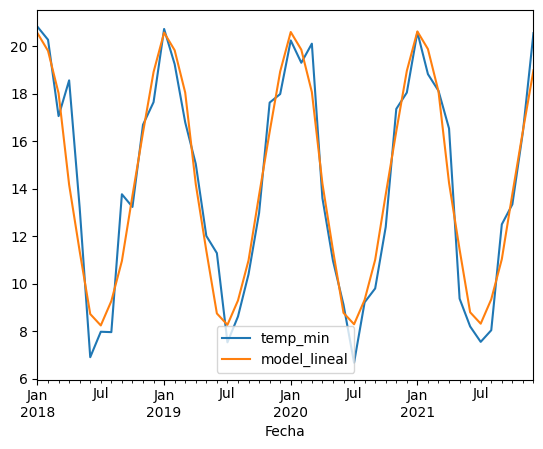

In [72]:
df_test_pred.plot(kind = "line", y = ['temp_min','model_lineal'])



Aplicamos el pipeline a la temperatura maxima

In [74]:
pipe.fit(df_train,df_train['temp_max'])

Pipeline(steps=[('Create_dummies', Create_month_dummies()),
                ('Feature_selection',
                 FeatureSelection(selected_features=['timeIndex', 'feb', 'mar',
                                                     'apr', 'may', 'jun', 'jul',
                                                     'aug', 'sep', 'oct', 'nov',
                                                     'dec'])),
                ('Linear_model',
                 SMWrapper(model_class=<class 'statsmodels.regression.linear_model.OLS'>))])

In [75]:
pipe.predict(df_train)

Fecha
1950-01    29.533697
1950-02    28.184270
1950-03    26.125918
1950-04    22.280920
1950-05    18.796648
             ...    
2017-08    17.927071
2017-09    19.771053
2017-10    22.725553
2017-11    25.973749
2017-12    28.989832
Freq: M, Length: 816, dtype: float64

In [76]:
pipe.predict(df_test)

Fecha
2018-01    30.501406
2018-02    29.151979
2018-03    27.093627
2018-04    23.248629
2018-05    19.764357
2018-06    16.398813
2018-07    15.999636
2018-08    17.941302
2018-09    19.785284
2018-10    22.739784
2018-11    25.987980
2018-12    29.004063
2019-01    30.515637
2019-02    29.166211
2019-03    27.107858
2019-04    23.262860
2019-05    19.778588
2019-06    16.413044
2019-07    16.013867
2019-08    17.955533
2019-09    19.799515
2019-10    22.754015
2019-11    26.002211
2019-12    29.018294
2020-01    30.529868
2020-02    29.180442
2020-03    27.122089
2020-04    23.277091
2020-05    19.792819
2020-06    16.427275
2020-07    16.028098
2020-08    17.969764
2020-09    19.813746
2020-10    22.768246
2020-11    26.016442
2020-12    29.032525
2021-01    30.544099
2021-02    29.194673
2021-03    27.136320
2021-04    23.291322
2021-05    19.807050
2021-06    16.441506
2021-07    16.042329
2021-08    17.983995
2021-09    19.827977
2021-10    22.782477
2021-11    26.030673
2021-12

In [77]:
RMSE(pipe.predict(df_train),df_train['temp_max'])

1.2498137766895765

In [78]:
RMSE(pipe.predict(df_test),df_test['temp_max'])

1.0110181249612258

In [79]:
df_test_pred = df_test
df_test_pred['model_lineal'] = pipe.predict(df_test)

<AxesSubplot:xlabel='Fecha'>

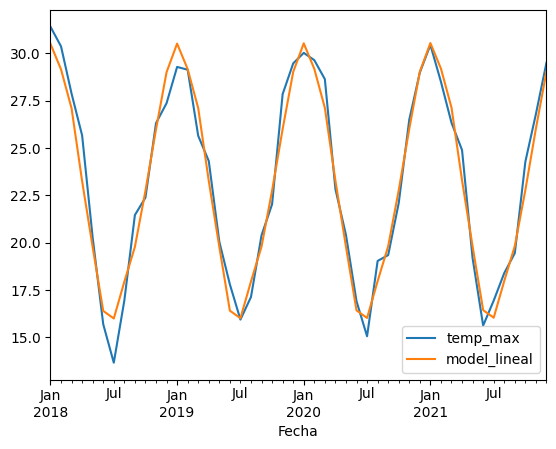

In [81]:
df_test_pred.plot(kind = "line", y = ['temp_max','model_lineal'])